In [1]:
import os
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import tensorflow as tf

%matplotlib inline

C:\Users\Kalle\Anaconda3\envs\german\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
def load_img(path, size):
    img = Image.open(path)
    old_size = img.size

    ratio = float(size/max(old_size))
    new_size = tuple([int(x*ratio) for x in old_size])

    img = img.resize(new_size, Image.ANTIALIAS)
    delta_w = size - new_size[0]
    delta_h = size - new_size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    img = ImageOps.expand(img, padding)
    return np.array(img)
    
X_train = []
y_train = []
X_test = []
y_test = []

size = 28

for j in range(43):
    train_path = os.path.join('../images', 'train', str(j).rjust(2, '0'), '*.ppm')
    files = glob.glob(train_path)
    for file in files:
        X_train.append(load_img(file, size))
        y_train.append(j)
        
    test_path = os.path.join('../images', 'test', str(j).rjust(2, '0'), '*.ppm')
    files = glob.glob(test_path)
    for file in files:
        X_test.append(load_img(file, size))
        y_test.append(j)

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

print('Done')

Done


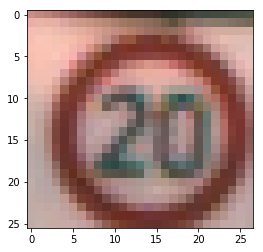

In [5]:
img = Image.open('../images/train/00/00001.ppm')
plt.imshow(img)

In [5]:
print(X_train.shape)
print(X_test.shape)

(773, 28, 28, 3)
(440, 28, 28, 3)


In [8]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_train2 = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test2 = enc.transform(y_test.reshape(-1,1)).toarray()

In [9]:
y_train2.shape

(773, 43)

## Gradient-Based Learning with LeNet model

**What is it?**

Pattern recognition systems perform better when built relying more on automatic learning and less on hand-designed heuristics. Usually the system is divided into two partes. First a feature extractor, which transforms the input patterns so that yjey can be represented by low-dimensional vectors that can be easily compared and are relatively invariant to transformations and distortions of the input patterns that don't change their nature. Secondly, a classifier which is often general-purpose and trainable.

To train this system, gradient-based learning is often used. A loss function  which compares the desired output with the predictions of the model is minimized with procedures like gradient descent. This is possible in non-linear systems with several layers of processing thanks to algorithms like back-propagation used to calculate gradients efficiently by propagation from the output to the input. 


A real-world example for logistic regression could be as a predictor for wether a patient has a disease, like diabetes, or not, based on certain characteristics of the patient like age, body mass index, sex, results tests, etc.

**Strengths of the model**

Multi-layer networks trained with gradient descent are capable to learn high-dimensional and non-linear mappings from large collections of examples. This makes them suitable for image recognition tasks.

The LeNet model uses a specific architecture known as Convolutional Networks. This type of networks combines local receptive fields, shared weights and spatial/temporal sub-sampling to ensure a certain degree of invariance to shift, scale and distortion in the input. The local receptive fields allow the network to extract elementary visual features that are combined in following layers to detect higher-order features.

Convolutional networks are particularly well suited for recognizing or rejecting shapes with widely varying size, position, and orientation.

**Weaknesses of the model**

This model also has it has its trade-offs and weaknesses. First of all, neural networks tend to be more computationally expensive and require large amounts of data to train. 


In [10]:
epochs = 10000
lr = 0.0003
num_classes = y_train2.shape[1]

In [11]:
def conv_layer(input_data, input_channels, filter_size, num_filters):
    W = tf.Variable(tf.truncated_normal(shape=[filter_size, filter_size, input_channels, num_filters], stddev=0.05))
    b = tf.Variable(tf.constant(0.05, shape=[num_filters]))
    
    layer = tf.nn.conv2d(input=input_data, filter=W, strides=[1, 1, 1, 1], padding='SAME')
    layer += b
    
    return layer

def fully_connected(input_data, num_inputs, num_outputs):
    W = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], stddev=0.05))
    b = tf.Variable(tf.constant(0.05, shape=[num_outputs]))
    
    return tf.matmul(input_data, W) + b

In [12]:
#Reset tensorflow graph
tf.reset_default_graph()

In [13]:
X_train[0].shape

(28, 28, 3)

In [14]:
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 3], name='x_input')
y_ = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_input')

print('Input:', x.get_shape())
c1 = conv_layer(input_data=x, input_channels=3, filter_size=5, num_filters=6)
# We choose a window_size of [1, 2, 2, 1] for a 2x2 window but 1 for batch and 
# channel dimensions because we don't want to take the maximum over multiple examples or channels
print('C1:', c1.get_shape())
s2 = tf.nn.pool(input=c1, window_shape=[2, 2], pooling_type='AVG', padding='SAME', strides=[2,2])
print('S2:', s2.get_shape())
a1 = tf.nn.relu(s2)
print('A1:', a1.get_shape())

c3 = conv_layer(input_data=a1, input_channels=6, filter_size=5, num_filters=16)
print('C3:', c3.get_shape())
s4 = tf.nn.pool(input=c3, window_shape=[2, 2], pooling_type='AVG', padding='SAME', strides=[2,2])
print('S4:', s4.get_shape())
a2 = tf.nn.relu(s4)

c5 = conv_layer(input_data=a2, input_channels=16, filter_size=5, num_filters=120)
print('C5:', c5.get_shape())

num_features = c5.get_shape()[1:4].num_elements()
flat = tf.reshape(c5, [-1, num_features])
f6 = fully_connected(input_data=flat, num_inputs=num_features, num_outputs=84)
print('F6:', f6.get_shape())
a3 = tf.nn.relu(f6)

output = fully_connected(input_data=a3, num_inputs=84, num_outputs=num_classes)
print('Output:', output.get_shape())

with tf.name_scope('Output'):
    y = tf.nn.softmax(output)

with tf.name_scope("Loss"):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y))
with tf.name_scope("declaring_gradient_descent"):
    # optimizer
    # we use gradient descent for our optimizer 
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss)
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

Input: (?, 28, 28, 3)
C1: (?, 28, 28, 6)
S2: (?, 14, 14, 6)
A1: (?, 14, 14, 6)
C3: (?, 14, 14, 16)
S4: (?, 7, 7, 16)
C5: (?, 7, 7, 120)
F6: (?, 84)
Output: (?, 43)


In [15]:
with tf.name_scope('Accuracy'):
    prediction = tf.argmax(y, 1, name='predict')
    correct = tf.equal(prediction, tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
saver = tf.train.Saver()

In [16]:
loss_hist = []
train_accs = []
test_accs = []

In [44]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
    
        _, loss = sess.run([optimizer, cost], feed_dict = {x: X_train, y_: y_train2})
        
        acc = sess.run(accuracy, feed_dict = {x: X_train, y_: y_train2})
        test_acc = sess.run(accuracy, feed_dict = {x: X_test, y_: y_test2})
        
        loss_hist.append(loss)
        train_accs.append(acc)
        test_accs.append(test_acc)
        
        if epoch % 2000 == 0:
            print('Epoch', epoch)
            print('Training accuracy:', acc)
            print('Test accuracy:', test_acc)
    print('Training finished')
    
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print('Accuracy:', accuracy.eval({x: X_test, y_: y_test2}))
    
    saver.save(sess, './model3')

Epoch 0
Training accuracy: 0.045738045
Test accuracy: 0.035856575
Epoch 2000
Training accuracy: 0.62785864
Test accuracy: 0.58964145
Epoch 4000
Training accuracy: 0.6902287
Test accuracy: 0.64143425
Epoch 6000
Training accuracy: 0.77858627
Test accuracy: 0.7171315
Epoch 8000
Training accuracy: 0.80457383
Test accuracy: 0.76494026
Training finished
Accuracy: 0.8366534
